# Random Forest Implementation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

Load in listing data from `LA_listing_feature_engineering.ipynb`

In [ ]:
listing_data = pd.read_pickle('listing_data_filtered_with_img.pkl')

Load in co-occurrance pairs from `Listing_Co_Occurrences.ipynb`

In [ ]:
positive_pairs_df = pd.read_pickle("positive_pairs_w_image.pkl")
negative_pairs_df = pd.read_pickle('negative_pairs_w_image.pkl')

## RF Setup

In [ ]:
# Add on response column y for pos/neg pair
positive_pairs_df_temp = positive_pairs_df.copy()
positive_pairs_df_temp['y'] = 1

negative_pairs_df_temp = negative_pairs_df.copy()
negative_pairs_df_temp['y'] = 0

# Stack positive/negative pairs into one df
all_data = pd.concat([positive_pairs_df_temp,negative_pairs_df_temp],axis=0)

In [ ]:
all_data.shape

(163168, 172)

In [ ]:
# Perform train test split stratified on anchor (here temporality doesnt make sense)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(['anchor','positive','negative','y'],axis=1), all_data['y'], test_size=0.2, random_state=297,
                                                    stratify=all_data['anchor'])

In [ ]:
# Verify that the train/test split is working as intended
X_train2, X_test2, y_train2, y_test2 = train_test_split(all_data, all_data['y'], test_size=0.2, random_state=297,
                                                    stratify=all_data['anchor'])
print(X_test2[X_test2.anchor=='535-geneva-st'].shape)
print(X_train2[X_train2.anchor=='535-geneva-st'].shape)
print(X_test2[X_test2.anchor=='535-geneva-st'].shape[0]/(X_test2[X_test2.anchor=='535-geneva-st'].shape[0]+X_train2[X_train2.anchor=='535-geneva-st'].shape[0]))

(134, 172)
(538, 172)
0.19940476190476192


### Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [80, 100, 120, 140],
    'max_depth': [20, 30, 40, 50],
    'min_samples_split': [10, 15, 20, 25],
    'min_samples_leaf': [1, 2]   
}

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=297)
gridSrch = GridSearchCV(rf, param_grid, cv = 3, verbose = 2)
rf_best = gridSrch.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=  16.4s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s


[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=  16.2s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=80, total=  16.3s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=  20.2s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=  20.0s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100, total=  20.0s
[CV] max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=120 
[CV]  max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=120, total=  24.0s
[CV] max_depth=20, min_samples_leaf=1, min_s

[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed: 148.3min finished


## Training

In [ ]:
gridSrch.best_params_

{'max_depth': 40,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 120}

In [ ]:
# Train random forest on co-occurrences
from sklearn.ensemble import RandomForestClassifier
np.random.seed(297)
regressor = RandomForestClassifier(n_estimators=120, max_depth=40, min_samples_leaf=1, min_samples_split=10, random_state=297) #best duplicates
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Investigate confusion matrix on this version of train/test split
# (separate from our main temporal train/test split)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[15488   952]
 [ 1266 14928]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     16440
           1       0.94      0.92      0.93     16194

    accuracy                           0.93     32634
   macro avg       0.93      0.93      0.93     32634
weighted avg       0.93      0.93      0.93     32634

0.9320340748912177


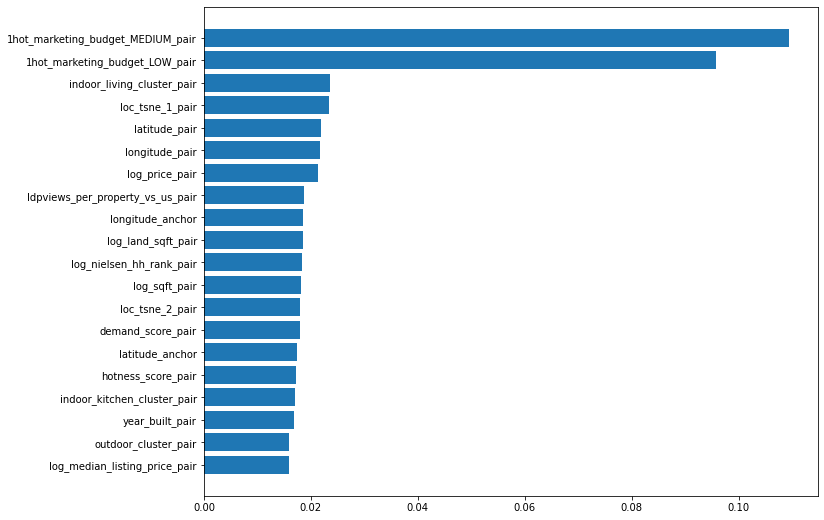

In [ ]:
# Visualize feature importance
sorted_idx = regressor.feature_importances_.argsort()[-20:]
plt.figure(figsize=(11,9))
plt.barh(positive_pairs_df.drop(['anchor','positive'],axis=1).columns[sorted_idx], regressor.feature_importances_[sorted_idx])
plt.show()

# Generate User Vectors: transform from listing-listing, to ip-listing 

Load in ip, listing data split on temporality from `Temporal_Train_Test_Split.ipynb`


In [ ]:
# Train and test will only contain users that have seen at least 3 listings
# Separate data from co-oc
user_listing_train = pd.read_pickle('ip_listing_temporal_train_full.pkl')
user_listing_test = pd.read_pickle('ip_listing_temporal_test_full.pkl')

In [ ]:
# Merge in actual listing data features to replace the rexUrl (listing name)
train_data = user_listing_train.merge(listing_data,left_on='rexUrl',right_on='rex_url')
train_data.drop(['rexUrl','rex_url'],axis=1,inplace=True)

test_data = user_listing_test.merge(listing_data,left_on='rexUrl',right_on='rex_url')

In [ ]:
# Get user house vector by MEDIANING all listings they saw in training
user_averaged_train = train_data.groupby('ip').median()
user_averaged_train.reset_index(inplace=True)

In [ ]:
user_averaged_train.head()

,ip,total_baths,stories,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,bedrooms,full_baths,half_baths,year_built,latitude,longitude,is_apt,hotness_score,demand_score,supply_score,ldpviews_per_property_vs_us,loc_tsne_1,loc_tsne_2,1hot_marketing_budget_LOW,1hot_marketing_budget_MEDIUM,1hot_marketing_budget_SURGE,1hot_property_type_CONDO,1hot_property_type_COOP,1hot_property_type_MULTI_FAMILY,1hot_property_type_SINGLE,1hot_property_type_TOWNHOUSE,1hot_pool_spa_types_Community Pool or Spa,1hot_pool_spa_types_Heated Pool,1hot_pool_spa_types_In Ground,1hot_pool_spa_types_No,1hot_pool_spa_types_Pool & Spa (both),1hot_pool_spa_types_Pool (yes),1hot_pool_spa_types_Spa (only),1hot_home_style_Bungalow,1hot_home_style_Cape Cod,1hot_home_style_Contemporary,1hot_home_style_Mediterranean,...,1hot_fencing_description_Average Condition,1hot_fencing_description_Back Yard,1hot_fencing_description_Block,1hot_fencing_description_Block Wall,1hot_fencing_description_Chain Link,1hot_fencing_description_Excellent Condition,1hot_fencing_description_Good Condition,1hot_fencing_description_None,1hot_fencing_description_Other,1hot_fencing_description_Other/Remarks,1hot_fencing_description_Partial,1hot_fencing_description_Privacy,1hot_fencing_description_Stucco Wall,1hot_fencing_description_Vinyl,1hot_fencing_description_Wood,1hot_fencing_description_Wrought Iron,1hot_property_condition_Additions/Alter,1hot_property_condition_Additions/Alterations,1hot_property_condition_Building Permit,1hot_property_condition_Fixer,1hot_property_condition_Other,1hot_property_condition_Repairs Cosmetic,1hot_property_condition_Repairs Major,1hot_property_condition_Termite Clearance,1hot_property_condition_Turnkey,1hot_property_condition_Updated/Remodeled,log_price,log_sqft,log_median_listing_price,log_median_days_on_market,log_nielsen_hh_rank,log_land_sqft,log_total_rooms,outdoor_cluster,indoor_bathroom_cluster,indoor_bedroom_cluster,indoor_dining_cluster,indoor_kitchen_cluster,indoor_living_cluster,indoor_other_cluster
0,1.129.109.119,2.00,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983.0,34.150675,-118.189237,0.0,75.919680,81.637776,70.201584,1.66910,7.913253,5.565733,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.244581,7.546446,13.377083,3.688879,7.552237,8.791182,1.945910,0.0,1.0,2.0,-1.0,1.0,1.0,2.0
1,1.65.170.128,2.00,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,1985.0,34.538646,-118.062533,0.0,72.534605,59.756002,54.835673,1.18120,-5.643898,-0.342706,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,12.701394,7.063048,12.706999,3.871201,7.523481,10.818417,1.609438,0.0,1.0,0.0,-1.0,0.0,2.0,-1.0
2,100.1.126.45,2.00,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1956.0,34.154569,-118.193838,0.0,52.772766,37.673543,70.201584,0.82350,6.102357,-0.162682,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.499429,7.543273,13.710206,3.688879,7.990577,8.745125,1.609438,1.0,1.0,1.0,-1.0,0.0,3.0,2.0
3,100.1.133.99,3.00,2.0,0.0,0.0,0.0,0.0,0.0,4.0,2.5,0.0,1969.5,34.177295,-118.468256,0.0,61.524433,40.038434,83.010432,0.86395,11.042698,-5.345970,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.616137,7.483805,13.946102,3.475407,7.976830,8.727770,1.868835,0.0,-1.0,-1.0,-1.0,1.5,0.5,-1.0
4,100.11.144.137,2.25,2.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1972.0,34.155082,-118.341700,0.5,42.995529,29.516040,51.564829,0.71325,3.019464,-1.764573,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.

In [ ]:
# Save user vectors for use in Siamese NN as well
# user_averaged_train.to_pickle('temporal_train_user_medianed.pkl')

## Match each user to all other listings they did not observe in the training data, and make predictions of pair/co-occurrence

In [ ]:
# Subset the list of all listings to only ones that have been seen by users (within train or test)
unique_rexurls = list( set(user_listing_train.rexUrl) | set(user_listing_test.rexUrl) )
observed_listings = listing_data[listing_data.rex_url.isin(unique_rexurls)].copy()

In [ ]:
# Pair each user with every listing
# cross join of user_averaged listings and every other listing
user_averaged_train['key'] = 1
observed_listings['key'] = 1
  
all_pairs = pd.merge(user_averaged_train, observed_listings, on ='key',suffixes=('_train','_test')).drop("key", 1) 

user_averaged_train.drop('key',axis=1,inplace=True)
observed_listings.drop('key',axis=1,inplace=True)

In [ ]:
# Merge in listings url that were included/seen in train set to identify and remove those rows, so as not to test on listings we already know they saw
seen_joined = all_pairs.merge(user_listing_train,left_on=['ip','rex_url'],right_on=['ip','rexUrl'],how='left')
idx_seen = np.where(seen_joined.rexUrl.notna())[0]

In [ ]:
print(len(idx_seen))
print(user_listing_train.shape)

51060
(51060, 2)


In [ ]:
# clear up ram
del seen_joined

In [ ]:
# Drop rows that were already seen in train set
all_pairs = all_pairs.drop(index=idx_seen)

Final Data for Prediction

In [ ]:
# Num Users, listings involved in testing
print('unique users (ips)', all_pairs.ip.nunique())
print('unique rexurls', all_pairs.rex_url.nunique())

unique users (ips) 8663
unique rexurls 466


In [ ]:
all_pairs.shape

(3985898, 170)

In [ ]:
all_pairs.head()

,ip,total_baths_train,stories_train,has_central_air_train,has_jacuzzi_train,has_pool_train,has_solar_train,has_garage_train,bedrooms_train,full_baths_train,half_baths_train,year_built_train,latitude_train,longitude_train,is_apt_train,hotness_score_train,demand_score_train,supply_score_train,ldpviews_per_property_vs_us_train,loc_tsne_1_train,loc_tsne_2_train,1hot_marketing_budget_LOW_train,1hot_marketing_budget_MEDIUM_train,1hot_marketing_budget_SURGE_train,1hot_property_type_CONDO_train,1hot_property_type_COOP_train,1hot_property_type_MULTI_FAMILY_train,1hot_property_type_SINGLE_train,1hot_property_type_TOWNHOUSE_train,1hot_pool_spa_types_Community Pool or Spa_train,1hot_pool_spa_types_Heated Pool_train,1hot_pool_spa_types_In Ground_train,1hot_pool_spa_types_No_train,1hot_pool_spa_types_Pool & Spa (both)_train,1hot_pool_spa_types_Pool (yes)_train,1hot_pool_spa_types_Spa (only)_train,1hot_home_style_Bungalow_train,1hot_home_style_Cape Cod_train,1hot_home_style_Contemporary_train,1hot_home_style_Mediterranean_train,...,1hot_fencing_description_Average Condition_test,1hot_fencing_description_Back Yard_test,1hot_fencing_description_Block_test,1hot_fencing_description_Block Wall_test,1hot_fencing_description_Chain Link_test,1hot_fencing_description_Excellent Condition_test,1hot_fencing_description_Good Condition_test,1hot_fencing_description_None_test,1hot_fencing_description_Other_test,1hot_fencing_description_Other/Remarks_test,1hot_fencing_description_Partial_test,1hot_fencing_description_Privacy_test,1hot_fencing_description_Stucco Wall_test,1hot_fencing_description_Vinyl_test,1hot_fencing_description_Wood_test,1hot_fencing_description_Wrought Iron_test,1hot_property_condition_Additions/Alter_test,1hot_property_condition_Additions/Alterations_test,1hot_property_condition_Building Permit_test,1hot_property_condition_Fixer_test,1hot_property_condition_Other_test,1hot_property_condition_Repairs Cosmetic_test,1hot_property_condition_Repairs Major_test,1hot_property_condition_Termite Clearance_test,1hot_property_condition_Turnkey_test,1hot_property_condition_Updated/Remodeled_test,log_price_test,log_sqft_test,log_median_listing_price_test,log_median_days_on_market_test,log_nielsen_hh_rank_test,log_land_sqft_test,log_total_rooms_test,outdoor_cluster_test,indoor_bathroom_cluster_test,indoor_bedroom_cluster_test,indoor_dining_cluster_test,indoor_kitchen_cluster_test,indoor_living_cluster_test,indoor_other_cluster_test
0,1.129.109.119,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983.0,34.150675,-118.189237,0.0,75.91968,81.637776,70.201584,1.6691,7.913253,5.565733,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.757776,7.465655,14.400543,3.806662,8.899185,8.919319,1.945910,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1.129.109.119,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983.0,34.150675,-118.189237,0.0,75.91968,81.637776,70.201584,1.6691,7.913253,5.565733,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.102161,6.894670,13.444519,3.610918,8.236421,10.887643,1.609438,1.0,-1.0,-1.0,-1.0,2.0,2.0,-1.0
2,1.129.109.119,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983.0,34.150675,-118.189237,0.0,75.91968,81.637776,70.201584,1.6691,7.913253,5.565733,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,14.343193,7.210080,15.404756,5.398163,8.734077,10.827885,1.609438,3.0,1.0,2.0,0.0,0.0,1.0,-1.0
3,1.129.109.119,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983.0,34.150675,-118.189237,0.0,75.91968,81.637776,70.201584,1.6691,7.913253,5.565733,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13.687677,7.403061,14.152019,3.912023,6.937314,8.783856,1.609438,2.0,3.0,-1.0,3.0,1.0,2.0,-1.0
4,1.129.109.119,2.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1983

In [ ]:
# Saving out for use in Siamese NN
# all_pairs.to_csv('user_medianed_paired_unseen_w_images.csv')

#### Predicting probability user "co-occurred" with each unseen listing
Perform prediction in chunks for RAM

In [ ]:
# Probability Predictions
total_len = all_pairs.shape[0]
preds_list = []
for i in range(10):
  all_pairs_p = all_pairs.iloc[int(i*total_len/10):int((i+1)*total_len/10)].copy()
  preds_list.append(regressor.predict_proba(all_pairs_p.drop(['rex_url','ip'],axis=1)))
  print(all_pairs_p.shape)

(398589, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398589, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398590, 170)


In [ ]:
# Combine probability predictions into one DF
temporal_pred_proba = np.concatenate(preds_list)
temporal_pred_proba.shape

(3985898, 2)

In [ ]:
# Binary predictions
preds_list_binary = []
for i in range(10):
  all_pairs_p = all_pairs.iloc[int(i*total_len/10):int((i+1)*total_len/10)].copy()
  preds_list_binary.append(regressor.predict(all_pairs_p.drop(['rex_url','ip'],axis=1)))
  print(all_pairs_p.shape)

(398589, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398589, 170)
(398590, 170)
(398590, 170)
(398590, 170)
(398590, 170)


In [ ]:
# Combine binary predictions into one DF
temporal_pred = np.concatenate(preds_list_binary)
temporal_pred.shape

(3985898,)

In [ ]:
# Create prediction result table
all_pairs_predictions = pd.DataFrame({'ip':all_pairs.ip,'rex_url':all_pairs.rex_url,'proba':temporal_pred_proba[:,1],'pred':temporal_pred})
all_pairs_predictions.sort_values('proba',ascending=False,inplace=True)
all_pairs_predictions.reset_index(drop=True,inplace=True)

In [ ]:
all_pairs_predictions.head()

,ip,rex_url,proba,pred
0,209.233.174.249,814-e-graves-ave,1.0,1
1,47.44.175.114,23552-park-south-st,1.0,1
2,64.60.154.146,23552-park-south-st,1.0,1
3,75.27.246.125,814-e-graves-ave,1.0,1
4,47.149.53.114,23552-park-south-st,1.0,1


In [ ]:
# Save user-listing predictions
# all_pairs_predictions = pd.read_pickle('all_pairs_predictions_w_images.pkl')

#### Distribution of prediction probabilities

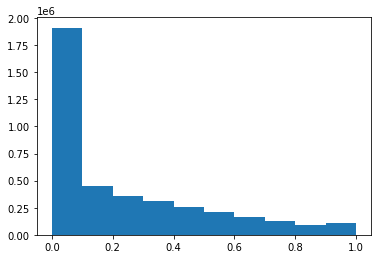

In [ ]:
plt.hist(all_pairs_predictions.proba)
plt.show()

### Precision/Recall Calculation

In [ ]:
# Set up precision/recall calculation function for given k 

def precision_recall_at_k(k_in):
  # get top k predictions for each ip
  g = all_pairs_predictions.groupby(['ip']).apply(lambda x: x.sort_values(['proba'], ascending = False)).reset_index(drop=True)
  top_k_each = g.groupby('ip').head(k_in)
  
  recommended_at_k = top_k_each[top_k_each.pred==1].groupby('ip')['rex_url'].apply(list).reset_index()

  recall_results = {}
  precision_results = {}
  #loop through each ip and compare recommended to real test set
  for idx, row in recommended_at_k.iterrows():
    ip_curr = row['ip']
    recommended_at_k_curr = row['rex_url']

    true_for_ip_curr = user_listing_test[user_listing_test.ip==ip_curr].rexUrl.values

    # Recommendations that are relevant
    # find overlap
    correctly_found_ip_curr = list(set(recommended_at_k_curr) & set(true_for_ip_curr))


    recall_results[ip_curr] = len(correctly_found_ip_curr)/len(true_for_ip_curr)
    precision_results[ip_curr] = len(correctly_found_ip_curr)/len(recommended_at_k_curr)

  
  return recommended_at_k, recall_results, precision_results


10

In [ ]:
recommended_at_10, recall_at_10, precision_at_10 = precision_recall_at_k(10)

In [ ]:
# w/ images
print('precision@10: ', np.round(100*np.mean(list(precision_at_10.values())),2), '%')
print('recall@10: ', np.round(100*np.mean(list(recall_at_10.values())),2), '%')

precision@10:  4.21 %
recall@10:  24.59 %


In [ ]:
print('precision@10: ', np.round(100*np.mean(list(precision_at_10.values())),2), '%')
print('recall@10: ', np.round(100*np.mean(list(recall_at_10.values())),2), '%')

precision@10:  4.12 %
recall@10:  24.28 %


In [ ]:
print('precision@10: ', np.round(100*np.mean(list(precision_at_10.values())),2), '%')
print('recall@10: ', np.round(100*np.mean(list(recall_at_10.values())),2), '%')

precision@10:  4.24 %
recall@10:  24.7 %


20

In [ ]:
recommended_at_20, recall_at_20, precision_at_20 = precision_recall_at_k(20)

In [ ]:
# w/ images
print('precision@20: ', np.round(100*np.mean(list(precision_at_20.values())),2), '%')
print('recall@20: ', np.round(100*np.mean(list(recall_at_20.values())),2), '%')

precision@20:  3.22 %
recall@20:  37.07 %


In [ ]:
print('precision@20: ', np.round(100*np.mean(list(precision_at_20.values())),2), '%')
print('recall@20: ', np.round(100*np.mean(list(recall_at_20.values())),2), '%')

precision@20:  3.18 %
recall@20:  36.64 %


30

In [ ]:
recommended_at_30, recall_at_30, precision_at_30 = precision_recall_at_k(30)

In [ ]:
# w/ images
print('precision@30: ', np.round(100*np.mean(list(precision_at_30.values())),2), '%')
print('recall@30: ', np.round(100*np.mean(list(recall_at_30.values())),2), '%')

precision@30:  2.81 %
recall@30:  47.66 %


In [ ]:
print('precision@30: ', np.round(100*np.mean(list(precision_at_30.values())),2), '%')
print('recall@30: ', np.round(100*np.mean(list(recall_at_30.values())),2), '%')

precision@30:  2.75 %
recall@30:  46.77 %


ALL

In [ ]:
recommended_at_all, recall_at_all, precision_at_all = precision_recall_at_k(9999999)

In [ ]:
# w/ images
print('precision overall: ', np.round(100*np.mean(list(precision_at_all.values())),2), '%')
print('recall overall: ', np.round(100*np.mean(list(recall_at_all.values())),2), '%')

precision overall:  1.66 %
recall overall:  72.29 %


In [ ]:
print('precision overall: ', np.round(100*np.mean(list(precision_at_all.values())),2), '%')
print('recall overall: ', np.round(100*np.mean(list(recall_at_all.values())),2), '%')

precision overall:  1.67 %
recall overall:  71.35 %


## Example Predictions

In [ ]:
train_la = user_listing_train.copy()
test_la = user_listing_test.copy()

In [ ]:
def predict_case(ip_in,k_in):
  '''
  Function that produces top k random forest predictions for a specific user/ip
  Displays: user vector, user's train set of listings they saw, the users true test set of listings they eventually saw and RF's predictions
  Also displays feature distributions of train (as boxplot), test and predicted homes (as points)
  '''

  # Useful listing features to be displayed
  cols = ['rex_url','sqft','price','bedrooms','total_rooms','full_baths','is_apt']

  # Setup dataframe of user-vector for easy visualization
  user_vector = user_averaged_train[user_averaged_train.ip==ip_in].copy()
  user_vector['sqft'] = np.exp(user_vector['log_sqft']).map('{:,.0f}'.format)
  user_vector['price'] = np.exp(user_vector['log_price']).map('{:,.0f}'.format)
  user_vector['total_rooms'] = np.exp(user_vector['log_total_rooms'])

  # Setup dataframe of training data for easy visualization
  training_case = train_la[train_la.ip==ip_in].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
  training_case['sqft'] = np.exp(training_case['log_sqft']).map('{:,.0f}'.format)
  training_case['price'] = np.exp(training_case['log_price']).map('{:,.0f}'.format)
  training_case['total_rooms'] = np.exp(training_case['log_total_rooms'])
  training_case['nsqft'] = np.exp(training_case['log_sqft'])
  training_case['nprice'] = np.exp(training_case['log_price'])

  # Setup dataframe of testing data for easy visualization
  testing_case = test_la[test_la.ip==ip_in].merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
  testing_case['sqft'] = np.exp(testing_case['log_sqft']).map('{:,.0f}'.format)
  testing_case['price'] = np.exp(testing_case['log_price']).map('{:,.0f}'.format)
  testing_case['total_rooms'] = np.exp(testing_case['log_total_rooms'])
  testing_case['nsqft'] = np.exp(testing_case['log_sqft'])
  testing_case['nprice'] = np.exp(testing_case['log_price'])

  # Make recommendations
  preds_for_ip_curr = all_pairs_predictions[(all_pairs_predictions.ip==ip_in)].copy()
  preds_for_ip_curr.sort_values('proba',inplace=True,ascending=False)
  top_k_for_ip_curr = preds_for_ip_curr.head(k_in)
  recommended_at_k = top_k_for_ip_curr[top_k_for_ip_curr.pred==1].rex_url.values   # Recommended items

 # Setup dataframe of recommendations for easy visualization
  toprecs_case = pd.DataFrame({'rexUrl':recommended_at_k})
  toprecs_case = toprecs_case.merge(listing_data,left_on='rexUrl',right_on='rex_url',how='left')
  toprecs_case['sqft'] = np.exp(toprecs_case['log_sqft']).map('{:,.0f}'.format)
  toprecs_case['price'] = np.exp(toprecs_case['log_price']).map('{:,.0f}'.format)
  toprecs_case['total_rooms'] = np.exp(toprecs_case['log_total_rooms'])
  toprecs_case['nsqft'] = np.exp(toprecs_case['log_sqft'])
  toprecs_case['nprice'] = np.exp(toprecs_case['log_price'])

  # re-sorting top 10 recommendations by euclidean distance to medianed user vector
  compare_cols = list(user_vector.columns[1:])
  toprecs_case['euclidean_dist'] = sp.spatial.distance.cdist(user_vector[data_cols],toprecs_case[data_cols], 'euclidean',w=weights)[0]
  toprecs_case.sort_values('euclidean_dist',inplace=True)

  
  # Displaying dataframes
  print('User Median')
  display(user_vector[cols[1:]])

  print('Train')
  display(training_case[cols])

  print('Test')
  display(testing_case[cols])

  print('Predicted')
  display(toprecs_case[cols])


  # Plotting listing distributions
  fig, axs = plt.subplots(1,3,figsize=(25,6))

  for ax, col in zip(axs.ravel(),['nprice','nsqft','total_rooms']):

    ax.boxplot(training_case[col])
    ax.scatter(np.ones(testing_case.shape[0]),testing_case[col],label='Test')
    ax.scatter(1.1*np.ones(toprecs_case.shape[0]),toprecs_case[col],label='Pred',color='red')
    ax.legend()
    ax.set_title(col)
  
  plt.show()

User Median


,sqft,price,bedrooms,total_rooms,full_baths,is_apt
142,"1,736","630,000",3.0,7.0,2.0,0.0


Train


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,13514-chivers-ave,"1,736","630,000",4.0,7.0,2.0,0.0
1,9735-baden-ave,"7,825","2,000,000",7.0,7.0,5.0,0.0
2,656-w-avenue-j8,768,"219,000",2.0,3.0,1.0,0.0
3,19970-e-limecrest-dr,"2,364","950,000",3.0,8.0,3.0,0.0
4,3501-knoll-crest-ave,"2,504","1,290,000",3.0,8.0,3.0,0.0
5,12750-centralia-st-unit-103,844,"312,900",1.0,3.0,1.0,1.0
6,6210-s-van-ness-ave,"1,448","515,000",3.0,6.0,2.0,0.0


Test


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,22718-figueroa-st-unit-21,"1,367","433,000",4.0,5.0,2.0,1.0
1,3591-soledad-canyon-rd,"1,680","575,000",3.0,7.0,2.0,0.0
2,6345-colbath-ave,"1,633","779,000",3.0,7.0,2.0,0.0


Predicted


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
1,22718-figueroa-st-unit-21,"1,367","433,000",4.0,5.0,2.0,1.0
8,1453-eagle-park-rd-apt-207,"1,005","350,000",2.0,4.0,2.0,1.0
9,44629-17th-st-e,"1,581","275,000",3.0,7.0,3.0,0.0
6,6345-colbath-ave,"1,633","779,000",3.0,7.0,2.0,0.0
4,9625-sylmar-ave-unit-36,"1,096","365,000",3.0,6.0,2.0,1.0
5,3332-genoa-pl,"3,163","491,837",5.0,10.0,3.0,0.0
3,814-e-graves-ave,"1,126","635,000",3.0,7.0,2.0,0.0
2,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
7,1509-inverness-dr,"3,244","2,525,000",4.0,8.0,2.0,0.0
0,23552-park-south-st,"5,910","2,999,999",5.0,8.0,5.0,0.0


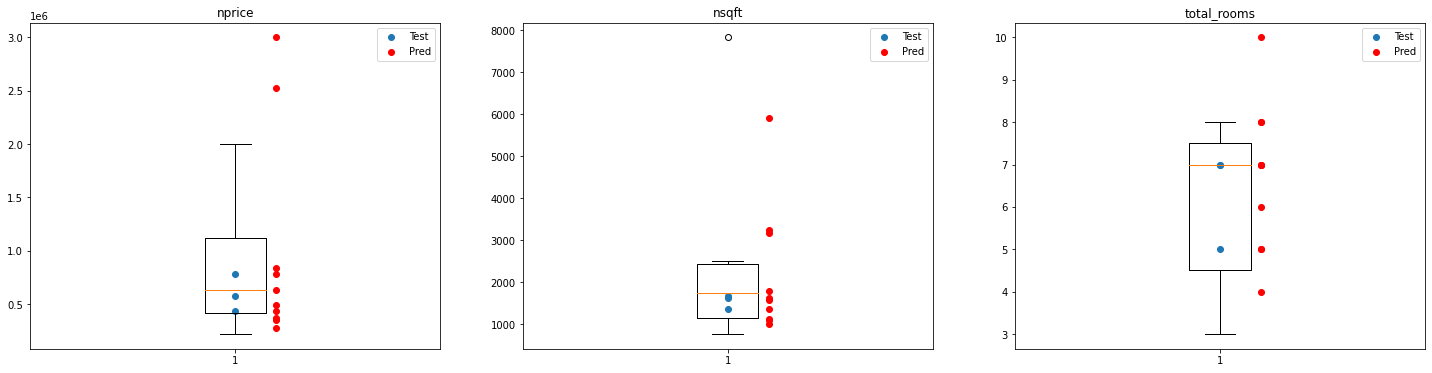

In [ ]:
predict_case('104.173.187.33',10)

User Median


,sqft,price,bedrooms,total_rooms,full_baths,is_apt
3941,"1,886","503,285",4.0,6.0,3.0,0.0


Train


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,6954-rubio-ave,"2,033","895,000",4.0,6.0,3.0,0.0
1,22015-liggett-st,"2,440","780,000",5.0,4.0,3.0,0.0
2,37526-ruby-red-ln,"2,815","435,000",4.0,9.0,3.0,0.0
3,13775-glenoaks-blvd-unit-27,"1,327","450,000",3.0,6.0,3.0,1.0
4,19425-keswick-st,"1,312","605,000",3.0,5.0,2.0,0.0
5,8541-alcott-st-unit-203,"1,750","949,000",4.0,6.0,3.0,1.0
6,3332-genoa-pl,"3,163","491,837",5.0,10.0,3.0,0.0
7,39322-longhorn-ct,"2,302","412,371",4.0,7.0,3.0,0.0
8,3433-satin-ct,"1,750","370,000",4.0,6.0,2.0,0.0
9,6210-s-van-ness-ave,"1,448","515,000",3.0,6.0,2.0,0.0


Test


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,23552-park-south-st,"5,910","2,999,999",5.0,8.0,5.0,0.0
1,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
2,22301-cass-ave,"2,288","920,000",4.0,12.0,2.0,0.0
3,10444-bevis-ave,"1,325","585,000",3.0,5.0,2.0,0.0


Predicted


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
6,44629-17th-st-e,"1,581","275,000",3.0,7.0,3.0,0.0
8,36144-37th-st-e,"1,780","500,000",3.0,5.0,2.0,0.0
4,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
1,9625-sylmar-ave-unit-36,"1,096","365,000",3.0,6.0,2.0,1.0
3,22718-figueroa-st-unit-21,"1,367","433,000",4.0,5.0,2.0,1.0
9,1453-eagle-park-rd-apt-207,"1,005","350,000",2.0,4.0,2.0,1.0
5,6345-colbath-ave,"1,633","779,000",3.0,7.0,2.0,0.0
0,814-e-graves-ave,"1,126","635,000",3.0,7.0,2.0,0.0
7,711-orange-grove-ave-unit-9,"1,028","495,000",2.0,5.0,2.0,1.0
2,23552-park-south-st,"5,910","2,999,999",5.0,8.0,5.0,0.0


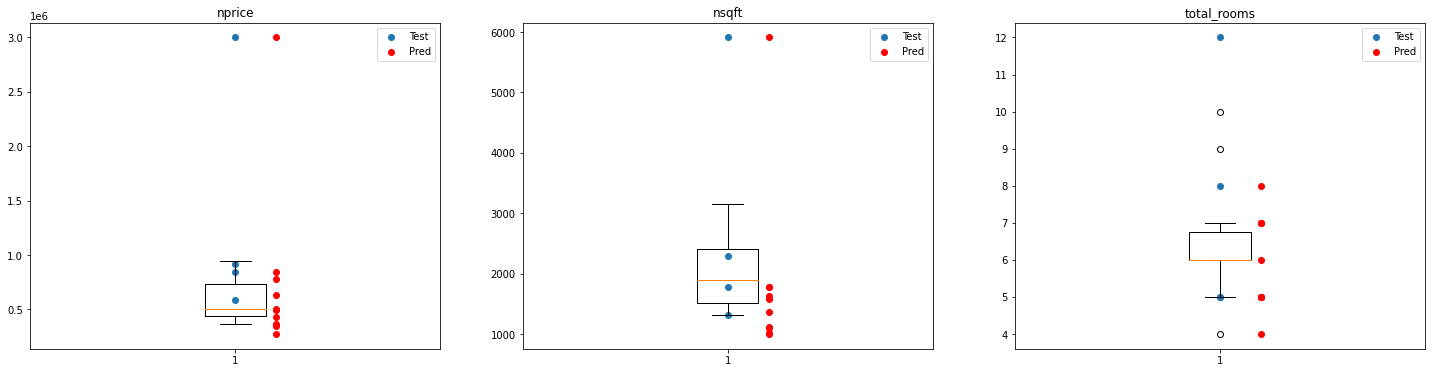

In [ ]:
predict_case('172.58.31.164',10)

Train


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,1509-inverness-dr,"3,244","2,525,000",4.0,8.0,2.0,0.0
1,2314-ginger-ct,"4,384","1,279,999",8.0,8.0,6.0,0.0
2,1050-trevecca-pl,"5,004","1,788,000",6.0,7.0,5.0,0.0
3,42437-boulder-dr,"1,522","333,333",3.0,6.0,2.0,0.0
4,2463-corralitas-dr,"1,978","1,200,000",3.0,9.0,3.0,0.0
5,9323-alcott-st-apt-101,"2,588","1,329,999",5.0,17.0,5.0,1.0
6,5342-n-ranger-dr,"2,898","772,000",5.0,5.0,4.0,0.0
7,4545-tyrone-ave,"2,375","1,299,000",3.0,4.0,2.0,0.0
8,1621-vineyard-ave-apt-4,903,"486,000",2.0,5.0,2.0,1.0


Test


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,27632-muir-grove-way,"3,066","689,500",5.0,9.0,4.0,0.0
1,17719-posetano-rd,"2,500","3,550,000",3.0,6.0,3.0,0.0
2,24718-via-kostas,"2,425","879,000",3.0,8.0,3.0,0.0


Predicted


,rex_url,sqft,price,bedrooms,total_rooms,full_baths,is_apt
0,23552-park-south-st,"5,910","2,999,999",5.0,8.0,5.0,0.0
1,814-e-graves-ave,"1,126","635,000",3.0,7.0,2.0,0.0
2,1415-n-myers-st,"1,782","840,000",5.0,5.0,3.0,0.0
3,6345-colbath-ave,"1,633","779,000",3.0,7.0,2.0,0.0
4,9625-sylmar-ave-unit-36,"1,096","365,000",3.0,6.0,2.0,1.0
5,711-orange-grove-ave-unit-9,"1,028","495,000",2.0,5.0,2.0,1.0
6,6954-rubio-ave,"2,033","895,000",4.0,6.0,3.0,0.0
7,3332-genoa-pl,"3,163","491,837",5.0,10.0,3.0,0.0
8,3427-greensward-rd,"1,526","1,139,000",3.0,5.0,2.0,0.0
9,22718-figueroa-st-unit-21,"1,367","433,000",4.0,5.0,2.0,1.0


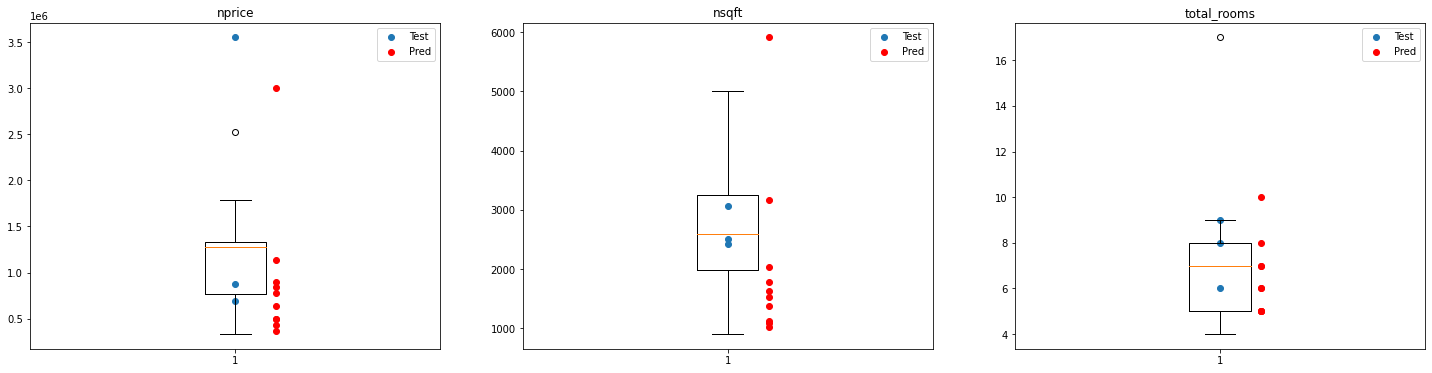

In [ ]:
predict_case('99.91.222.52',10)

## User Study

In [ ]:
import scipy as sp
from itertools import combinations 

In [ ]:
# Create all possible combinations of 3 selected listings from user study
user_testing_listings = ['840-e-green-st-unit-224', '175-sequoia-dr', '1245-cordova-st-unit-301', '18726-vista-del-canon-unit-e','2727-manning-ave','2022-delaware-ave-apt-4']
possible_combos = list(combinations(user_testing_listings, 3))

In [ ]:
# Within top 10 recommendations for user study,
# resort by euclidean distance to get the ideal top 1 recommendation

# Weighting for euclidean similarity
data_cols = list(listing_data.columns)[1:]
weights = np.ones(len(data_cols))

weights[data_cols.index('log_price')] = 90
weights[data_cols.index('bedrooms')] = 40
weights[data_cols.index('full_baths')] = 30
weights[data_cols.index('is_apt')] = 120

In [ ]:
# Loop through each combination of 3 listings chosen to predict top 1 recommendation
all_pairs_combo_for_siamese_list = []
top_predictions = {}

for combo_i in possible_combos:
  # Create a user vector from the 3 listings selected using median of listing features
  curr_combo = list(combo_i)
  curr_combo_listingdata = listing_data[listing_data.rex_url.isin(curr_combo)].median(axis=0).to_frame().T

  # Create list of all other listings (except the 3 selected) to predict against
  other_listings = listing_data[~listing_data.rex_url.isin(curr_combo)].copy()

  # Pair "combo user vector" to all other possible listings
  curr_combo_listingdata['key'] = 1
  other_listings['key'] = 1
  # cross join to get all pairings to predict on in 1 dataframe
  all_pairs_combo = curr_combo_listingdata.merge(other_listings, on ='key',suffixes=('_train','_test')).drop("key", 1) 
  curr_combo_listingdata.drop('key',axis=1,inplace=True)
  other_listings.drop('key',axis=1,inplace=True)

  # Save off a version to be used in the siamese model user study section
  all_pairs_combo_for_siamese = all_pairs_combo.copy()
  all_pairs_combo_for_siamese['triple'] = [combo_i]*all_pairs_combo_for_siamese.shape[0]
  all_pairs_combo_for_siamese_list.append(all_pairs_combo_for_siamese)

  # make predictions with RF
  preds_i = regressor.predict_proba(all_pairs_combo.drop(['rex_url'],axis=1))
  preds_i_binary = regressor.predict(all_pairs_combo.drop(['rex_url'],axis=1))

  # consolidate predictions into df
  curr_combo_predictions = pd.DataFrame({'rex_url':all_pairs_combo.rex_url,'proba':preds_i[:,1],'pred':preds_i_binary})
  curr_combo_predictions.sort_values('proba',ascending=False,inplace=True)

  # get top 10 predictions
  curr_combo_predictions = curr_combo_predictions.head(10)[curr_combo_predictions.head(10).pred==1].copy()

  # bring listing data back in for top 10, and resort within top 10 by weighted euclidean distance
  toprecs_curr = curr_combo_predictions.merge(listing_data,on='rex_url')
  toprecs_curr['euclidean_dist'] = sp.spatial.distance.cdist(curr_combo_listingdata,toprecs_curr[curr_combo_listingdata.columns], 'euclidean',w=weights)[0]
  toprecs_curr.sort_values('euclidean_dist',inplace=True)

  # save top 1 prediction for the 3 listings chosen
  top_predictions[combo_i] = toprecs_curr.head(1).rex_url.values[0]

In [ ]:
# Saving medianed triple with all its pairings to predict using siamese network
all_pairs_combo_for_siamese_df = pd.concat(all_pairs_combo_for_siamese_list,axis=0)
all_pairs_combo_for_siamese_df.to_pickle('all_pairs_user_test_for_siamese_df.pkl')

In [ ]:
# Organizing top predictions for each combination of 3 listings selected - to be used in question 2 of user study
top_predictions_df = pd.DataFrame.from_dict(top_predictions,orient='index')
top_predictions_df.rename({0:'top_prediction'},axis=1,inplace=True)
index_rows = []
for p in top_predictions_df.index:
  index_rows.append([np.argwhere(np.array(user_testing_listings)==i)[0][0]+1 for i in list(p)])

top_predictions_df['idxs'] = index_rows
top_predictions_df

,top_prediction,idxs
"(840-e-green-st-unit-224, 175-sequoia-dr, 1245-cordova-st-unit-301)",18350-hatteras-st-apt-103,"[1, 2, 3]"
"(840-e-green-st-unit-224, 175-sequoia-dr, 18726-vista-del-canon-unit-e)",18350-hatteras-st-apt-103,"[1, 2, 4]"
"(840-e-green-st-unit-224, 175-sequoia-dr, 2727-manning-ave)",6345-colbath-ave,"[1, 2, 5]"
"(840-e-green-st-unit-224, 175-sequoia-dr, 2022-delaware-ave-apt-4)",6345-colbath-ave,"[1, 2, 6]"
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 18726-vista-del-canon-unit-e)",18350-hatteras-st-apt-103,"[1, 3, 4]"
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 2727-manning-ave)",18350-hatteras-st-apt-103,"[1, 3, 5]"
"(840-e-green-st-unit-224, 1245-cordova-st-unit-301, 2022-delaware-ave-apt-4)",18350-hatteras-st-apt-103,"[1, 3, 6]"
"(840-e-green-st-unit-224, 18726-vista-del-canon-unit-e, 2727-manning-ave)",18350-hatteras-st-apt-103,"[1, 4, 5]"
"(840-e-green-st-unit-224, 18726-vista-del-canon-unit-e, 2022-delaware-ave-apt-4)",18350-hatteras-st-apt-103,"[1, 4, 6]"
"(840-e-green-st-unit-224, 2727-manning-ave, 2022-delaware-ave-apt-4)",6954-rubio-ave,"[1, 5, 6]"
